# Monte Carlo Simulation

References :  
* Option, Futures & Other Derivatives - John Hull - $10^{th}$ Edition - Chapter 21

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from math import *
import time
import scipy.stats

In [156]:
S0 = 100
K = 100 #ATM Call option
T = 1
sigma = 0.20
r = 0.01
mu = 0.15
n = 100 #Simulations number

###### 1 - Compute n stock prices paths with the Geometric Brownian motion

In [157]:
def GBM(S0,mu=0.15,sigma=0.3,T=1,n=100):
    BM = []
    steps = int(260*T) #Number of steps
    dt = T/steps #Time step
    
    tt = np.arange(0,T,dt) #Timesteps
    
    for sim in range(n): #Generates n paths
        S = np.zeros(steps)
        S[0] = S0
        for t in range(1,steps): #Simulates current Brownian motion
            drift = (mu - 0.5 * (sigma ** 2)) * dt
            dS = drift + sigma * np.random.normal(0,1) * np.sqrt(dt)
            S[t] = S[t-1] * np.exp(dS)
        BM.append(S)
    
    return BM

--- 0.13002347946166992 seconds --- 


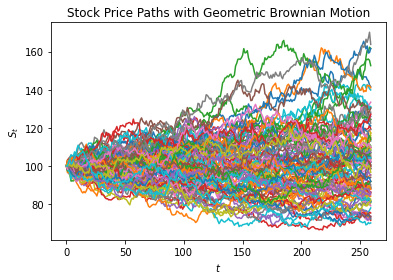

In [158]:
start_time = time.time()
BM = GBM(S0,r,sigma,T,n)
print("--- %s seconds --- " %(time.time() - start_time))
for B in BM:
    plt.plot(B)
plt.xlabel("$t$")
plt.ylabel("$S_{t}$")
plt.title("Stock Price Paths with Geometric Brownian Motion")
plt.show()

###### 2 - Monte Carlo Simulation to obtain the call option prices 

In [159]:
def MonteCarloEUCall(BM,K,r,T): #Monte Carlo for European Call options
    #BM List of stock prices paths 
    #K Strike 
    #r Risk free interest rate
    #T Maturity of the option
    call_payoffs = [max(B[-1] - K,0) for B in BM] #Call payoffs for each stock price path
    mean_payoffs = np.mean(call_payoffs)
    return call_payoffs, mean_payoffs * np.exp(-r*T) #payoffs , Discounted mean of the payoffs to get the option price

In [160]:
def empirical_sd(X): #Computes the empirical standard deviation of a series
    n = len(X)
    s = 0
    mu = np.mean(X)
    for x in X:
        s += (x - mu)**2
    return np.sqrt(s/(n-1))

In [161]:
def confidence_interval(call_payoffs,alpha):
    #call_payoffs List of the payoffs of the call options
    #alpha Incertitude level
    
    z = scipy.stats.norm.ppf(1-alpha/2)
    mean_payoffs = np.mean(call_payoffs)
    CI = [np.round(mean_payoffs - z * (empirical_sd(call_payoffs)/np.sqrt(n)),4),
        np.round(mean_payoffs + z * ((empirical_sd(call_payoffs)/np.sqrt(n))),4)]
    CI = np.exp(-r*T) * np.array(CI) #Discount the values
    return CI

In [162]:
call_payoffs1, c1 = MonteCarloEUCall(BM,K,r,T)

In [163]:
alpha = 0.01
call_payoffs = [max(B[-1] - K,0) for B in BM]
CI1 = confidence_interval(call_payoffs,alpha)

In [164]:
print(f"The price of the call using the Monte Carlo Method is equal to : {round(c1,4)}")
print(f"The confidence interval of the call price at a {(1 - alpha)*100}% confidence level is {CI1}")
print("--- %s seconds --- " %(time.time() - start_time))

The price of the call using the Monte Carlo Method is equal to : 9.9215
The confidence interval of the call price at a 99.0% confidence level is [ 6.04930349 13.79357229]
--- 2.3689513206481934 seconds --- 


###### 2 - Comparison with the Black-Scholes formula 

In [165]:
start_time = time.time()
d1 = (np.log(S0/K) + (r + sigma ** 2/2)*T)/(sigma*np.sqrt(T))
d2 = (np.log(S0/K) + (r - sigma ** 2/2)*T)/(sigma*np.sqrt(T))
c2 = S0 * scipy.stats.norm.cdf(d1) - K*np.exp(-r*T)*scipy.stats.norm.cdf(d2)
print(f"The price of the call using the Black-Scholes formula is equal to : {round(c2,4)}")
print("--- %s seconds --- " %(time.time() - start_time))

The price of the call using the Black-Scholes formula is equal to : 8.4333
--- 0.001001119613647461 seconds --- 


We obtain very close stock prices and the Black-Scholes formula takes fewer time to compute.

###### 3 - Variation of the Strike Price 

In [167]:
c = []
CI = []
for rate in np.arange(0.5,1.4,0.1):
    K = np.round(S0*rate,2)
    mc = MonteCarlo(BM,K,r,T)
    call_payoffs = mc[0]
    c.append(mc[1])
    CI.append(confidence_interval(call_payoffs,alpha))

In [168]:
print("For strikes ranging from 50% to 130% of the initial stock price, we obtain  the following call option prices :")
for index,price in enumerate(c):
    print(f"Call price : {round(price,4)} , Confidence interval : {CI[index]}")

For strikes ranging from 50% to 130% of the initial stock price, we obtain  the following call option prices :
Call price : 52.7403 , Confidence interval : [47.30755121 58.17305112]
Call price : 42.8398 , Confidence interval : [37.40705287 48.27255278]
Call price : 32.9393 , Confidence interval : [27.50655453 38.37205444]
Call price : 23.7112 , Confidence interval : [18.50700154 28.91549445]
Call price : 15.9862 , Confidence interval : [11.34587209 20.62650023]
Call price : 9.9215 , Confidence interval : [ 6.04930349 13.79357229]
Call price : 5.7291 , Confidence interval : [2.68966838 8.76857436]
Call price : 3.1583 , Confidence interval : [0.92114237 5.39547458]
Call price : 1.5661 , Confidence interval : [-0.00782139  3.14004205]


###### 4 - Variance reduction

In [169]:
def BetaEstimation(X,Y):
    num = 0
    denom = 0
    e1,e2 =  np.mean(X), np.mean(Y)
    for i,x in enumerate(X):
        num += (X[i] - e1) * (Y[i] - e2)
        denom += (X[i] - e1) ** 2
    return num/denom

In [170]:
K = 100
Y = [max(B[-1] - K,0) for B in BM] 
X = [B[-1] for B in BM]
beta = BetaEstimation(X,Y) #Coefficient that minimizes the variance
Z = Y - beta * (X - BM[0][0]) #Control Variate #BM[0][0] = E[Z]

In [171]:
var1 = np.var(Y)
var2 = np.var(Z)

In [172]:
print(f"Original Variance of the call price : {var1}")
print(f"Reduced Variance of the call price : {var2}")

Original Variance of the call price : 228.24192168794787
Reduced Variance of the call price : 33.3706982449479


###### 5 - Importance sampling for far  OTM call options

In [173]:
K = 1000 #Far OTM Strike

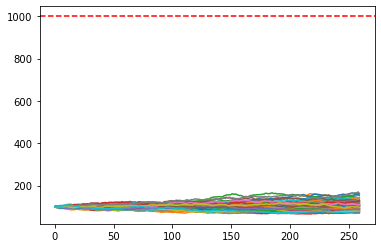

In [174]:
plt.figure()
for B in BM:
    plt.plot(B)
plt.axhline(y=K,color='r',linestyle='--')
plt.show()

The stock price path does not reach the strike price therefore, if we decide to compute a Monte Carlo simulation in this situation, the majority of the payoffs will be equal to 0 which will lead in an incorrect call price.

In [175]:
call_payoffs3, call_price3 = MonteCarloEUCall(BM,K,r,T)
print(f"The price of the call using the Monte Carlo Method is equal to : {round(call_price3,4)}")

The price of the call using the Monte Carlo Method is equal to : 0.0


We find the Radon-Nikodym derivative so the stock price converges towards $K$

In [176]:
mu = np.log(K/S0) #Switching the drift
BM = GBM(S0,mu,sigma,T,n)

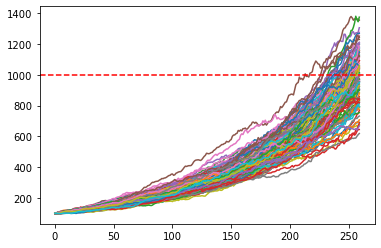

In [177]:
plt.figure()
for B in BM:
    plt.plot(B)
plt.axhline(y=K,color='r',linestyle='--')
plt.show()

In [178]:
call_payoffs4, call_price4 = MonteCarloEUCall(BM,K,r,T)
print(f"The price of the call using the Importance Sampling Monte Carlo Method is equal to : {round(call_price4,4)}")

The price of the call using the Importance Sampling Monte Carlo Method is equal to : 62.4035


###### 6 - Asian Option Pricing 

In [204]:
S0 = 100
K = 100 #ATM Call option
T = 1
sigma = 0.20
r = 0.01
mu = 0.15
n = 100 #Simulations number

In [210]:
def MonteCarloAsianCall(BM,K,r,T): #Monte Carlo for Asian Call options
    #BM List of stock prices paths 
    #K Strike 
    #r Risk free interest rate
    #T Maturity of the option
    call_payoffs = [max(np.mean(B) - K,0) for B in BM] #Call payoffs for each stock price path
    print(np.mean(B))
    mean_payoffs = np.mean(call_payoffs)
    return call_payoffs, mean_payoffs * np.exp(-r*T) #payoffs , Discounted mean of the payoffs to get the option price

In [211]:
BM = GBM(S0,mu,sigma,T,n)

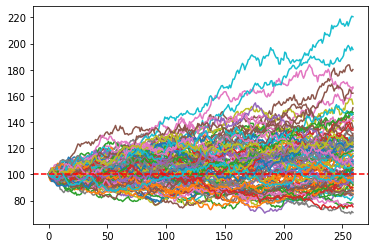

In [212]:
plt.figure()
for B in BM:
    plt.plot(B)
plt.axhline(y=K,color='r',linestyle='--')
plt.show()

In [213]:
call_payoffs5, asian_call1 = MonteCarloAsianCall(BM,K,r,T)
print(f"The price of the asian call using the Monte Carlo Method is equal to : {round(asian_call1,4)}")

96.87560746766334
The price of the asian call using the Monte Carlo Method is equal to : 9.6287
